# Tutorial Keras CS 5316 Natural Language Processing

In [1]:
%%capture
# import nltk
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Dense, Activation, RepeatVector,Flatten, TimeDistributed, Input,Bidirectional,LocallyConnected1D,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Concatenate,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM ,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from keras_self_attention import SeqSelfAttention
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras.utils.to_categorical as to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

First take a look at how [computational graphs](https://medium.com/tebs-lab/deep-neural-networks-as-computational-graphs-867fcaa56c9) in keras work. 

# Keras
Keras is a wrapper library that provides high-level building blocks for developing deep learning models while using other deep learning frameworks at its backend. For its backend keras can work with [Theano](https://github.com/Theano/Theano), [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) or [Tensorflow](https://www.tensorflow.org/). For our assignments we will be using Tensorflow. Keras provides user with two API's [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) and [Functional](https://www.tensorflow.org/guide/keras/functional) to build models. 

### Sequential API
In Sequential API layers are added one after another in a sequence, where output of previous layer is fed as input to the next layer. Lets build a feed forward network for text classification using Sequential API. Our model takes an input of size 300 and classifies the input into two classes. We add the first layer and specify the size of input it is to recieve this is your models input size which we defined as 300 before. input_shape is only required for the first layer, for the rest automatic shape inference is done by keras. As you can see in the example each layer has some parameters that are either automatically defined or you can define them yourself, for example for the second layer I have defined the activation function as "relu" and for the final layer the activation is "softmax". When you have defined all the layers in your model you must [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) it, for keras to configure it for training. 

In [3]:
model = tf.keras.Sequential()
model.add(Dense(100,activation='relu',input_shape=(300,)))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax',name="classifier"))
model.compile(optimizer='sgd', loss='categorical_crossentropy')

To view you model summary use can use the .summary() command. Lets go over what the command outputs, the column "Layer (type)" defines the name of each layer and the layers type in our case all of them are dense. Ther next column "Output Shape" defines the shape of the output here "None" refers to batch size that is defined when you train the model. The third column "Param #" defines the number of parameter/wieghts associated with the layer. Finally there is small section that shows trainable and non trainable parameter, non-trainable parameters are usually parameter of layers that are frozen or gradient calculation for such layer has been turned off.

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
classifier (Dense)           (None, 2)                 102       
Total params: 35,252
Trainable params: 35,252
Non-trainable params: 0
_________________________________________________________________


### Functional API
Now let us build the same model using Functional API. Functional API gives you more freedom to construct complex model that are not possible in Sequential API. Here each layer is defined as a callable variable or node as keras defines it.<br>
Except the input layer all layers in the model are connected pairwise, this is done by specifying where the input comes from when defining each new layer. A bracket notation is used, such that after the layer is created, the layer from which the input to the current layer comes from is specified.<br>
For example in this declaration "dense1= Dense(100,activation='relu')(input_layer)" a dense layer is bieng created which recieves its input from "input_layer". After all layers have been defined the inputs and output of the model must be specified so that keras can create the computation graph and after that the model is to be compiled as before.

In [5]:
input_layer = Input(shape=(300,))
dense1= Dense(100,activation='relu')(input_layer)
dense1= Dense(50,activation='relu')(dense1)
output_layer= Dense(2,activation='softmax',name="classifier")(dense1)
model2 = Model(inputs=[input_layer], outputs=[output_layer])
model2.compile(optimizer='sgd', loss='categorical_crossentropy')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
classifier (Dense)           (None, 2)                 102       
Total params: 35,252
Trainable params: 35,252
Non-trainable params: 0
_________________________________________________________________


# Dummy Example
Now lets take a look at some of the thing's that you will be using for your assignment by means of a small example. We will be using the sentence polarity dataset which is available in NLTK. This is a binary classification problem with positive and negative polarity as labels

In [6]:
import nltk
nltk.download('sentence_polarity')

[nltk_data] Downloading package sentence_polarity to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package sentence_polarity is already up-to-date!


True

In [7]:
from nltk.corpus import sentence_polarity
print(sentence_polarity.readme)

<bound method CategorizedSentencesCorpusReader.readme of <CategorizedSentencesCorpusReader in 'C:\\Users\\hamma\\AppData\\Roaming\\nltk_data\\corpora\\sentence_polarity'>>


In [8]:
data_X=[]
data_Y=[]
for category in sentence_polarity.categories():#load file names
    for fileid in sentence_polarity.fileids(category):#for each category        
        for sentence in sentence_polarity.sents(fileid):#for each file get sentences
            data_X.append(sentence)#make tupple
            data_Y.append(fileid)

# One hot Encoding

In [9]:
print(data_X[0])
print(data_Y[0])

['simplistic', ',', 'silly', 'and', 'tedious', '.']
rt-polarity.neg


In [10]:
#one hot encoding the labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data_Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded= onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [11]:
x_train, x_val, y_train, y_val = train_test_split(data_X, onehot_encoded, test_size=0.2, shuffle=True)

### Tokenizer
The tokenizer is used to convert word sequences into a numeric vector. Here the fix_on_text command assigns all the unique word in dataset a numeric representation*(this process is deterministic)*. text_to_sequence converts the data into numeric vectors.

In [12]:
#find max sequnce length for padding the input features X
max_seq_length=-1
for value in data_X:
    if(max_seq_length<len(value)):
        max_seq_length=len(value)
print(max_seq_length)

59


In [13]:
tokenizer = Tokenizer()#imported above
tokenizer.fit_on_texts(x_train)
x_train_numeric=tokenizer.texts_to_sequences(x_train)
x_val_numeric=tokenizer.texts_to_sequences(x_val)

print("Word Sequence \"",x_train[0],"\" is converted to numeric vector(without padding)",x_train_numeric[0],"\n\n")
x_train_numeric=pad_sequences(x_train_numeric,maxlen=max_seq_length,padding='post')#pad to max sequence length
x_val_numeric=pad_sequences(x_val_numeric,maxlen=max_seq_length,padding='post')#pad to max sequence length
print("Word Sequence \"",x_train[0],"\" is converted to numeric vector(with padding)",x_train_numeric[0])

Word Sequence " ['the', 'story', 'alone', 'could', 'force', 'you', 'to', 'scratch', 'a', 'hole', 'in', 'your', 'head', '.'] " is converted to numeric vector(without padding) [2, 45, 656, 109, 765, 23, 7, 1840, 4, 2645, 9, 73, 549, 1] 


Word Sequence " ['the', 'story', 'alone', 'could', 'force', 'you', 'to', 'scratch', 'a', 'hole', 'in', 'your', 'head', '.'] " is converted to numeric vector(with padding) [   2   45  656  109  765   23    7 1840    4 2645    9   73  549    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [14]:
# get vocabulary
vocabulary=list(tokenizer.word_index.keys())#get the vocabular
vocabulary=len(vocabulary)+1#vocabsize

In [15]:
print("Numeric assignments, as you can see zero is reserved for padding\n",tokenizer.word_index,"\n")

Numeric assignments, as you can see zero is reserved for padding
 {'.': 1, 'the': 2, ',': 3, 'a': 4, 'and': 5, 'of': 6, 'to': 7, 'is': 8, 'in': 9, 'that': 10, 'it': 11, 'as': 12, 'but': 13, 'with': 14, 'film': 15, 'this': 16, 'for': 17, 'its': 18, 'an': 19, 'movie': 20, "it's": 21, 'be': 22, 'you': 23, 'on': 24, 'not': 25, 'by': 26, 'about': 27, 'more': 28, 'one': 29, 'like': 30, 'at': 31, 'has': 32, 'are': 33, '"': 34, 'from': 35, 'than': 36, 'all': 37, '--': 38, 'his': 39, 'have': 40, 'so': 41, 'if': 42, 'or': 43, 'i': 44, 'story': 45, 'too': 46, 'just': 47, 'who': 48, 'most': 49, 'into': 50, 'out': 51, 'even': 52, 'what': 53, 'much': 54, 'will': 55, 'no': 56, 'good': 57, 'up': 58, 'some': 59, 'can': 60, 'time': 61, 'comedy': 62, 'characters': 63, 'little': 64, 'only': 65, 'way': 66, 'their': 67, 'funny': 68, 'make': 69, 'very': 70, 'been': 71, 'enough': 72, 'your': 73, 'when': 74, 'there': 75, 'work': 76, 'makes': 77, 'best': 78, 'never': 79, 'us': 80, 'which': 81, 'bad': 82, 'direc

Now that were done transforming our inputs let us define the model

In [16]:
EMBEDDING_DIM=150
###--- model define ---###
inputs = Input(shape=(max_seq_length,))
emb = Embedding(vocabulary,EMBEDDING_DIM,input_length=max_seq_length, trainable=True)(inputs)
lstm_out=Bidirectional(LSTM(150, return_sequences=False, return_state=False))(emb)#apply bidirectional lstm
out_classifier = Dense(2, activation='softmax',name='sentiment_classifier')(lstm_out)#take last output
###--- model define---###
model = Model(inputs=[inputs], outputs=[out_classifier])
model.compile(loss=["categorical_crossentropy"], optimizer='adam', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 59)                0         
_________________________________________________________________
embedding (Embedding)        (None, 59, 150)           2860950   
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               361200    
_________________________________________________________________
sentiment_classifier (Dense) (None, 2)                 602       
Total params: 3,222,752
Trainable params: 3,222,752
Non-trainable params: 0
_________________________________________________________________


Callbacks are usefull methods that are called after each epoch when the model is bieng trained. This is to passed as parameter to the model.fit() command which is used train the model.<br>
We have added 4 common callbacks, the purpose of each of these is as follows.
<ul>
    <li>CSVlogger streams results of each epoch to a csv file.</li>
    <li>EarlyStopping, this stops the training process given that therer is no change in the value bieng monitored for the number of epochs specified in patience parameter.</li>
    <li>ModelCheckpoint, this saves the wieghts of the model based on the value bieng monitored, primarly used to stop the model from over fitting the training set</li>
    <li>ReduceLROnPlateau, this reduces the learning rate based on the value bieng monitored, given that therer is no change in the value bieng monitored for the number of epochs specified in patience parameter</li>
</ul>    
Keras also allows you to create custom callbacks.

In [17]:
filepath = "setting_" + "model" + ".hdf5"
logfilepath = "setting_"+"model" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=2,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]



In [18]:
history=model.fit(x_train_numeric,y_train, epochs=20,batch_size=64,
               validation_data=(x_val_numeric, y_val),verbose=1,shuffle=True,callbacks=callbacks_list)


Train on 8529 samples, validate on 2133 samples
Epoch 1/20
8512/8529 [============================>.] - ETA: 0s - loss: 0.6346 - acc: 0.6241
Epoch 00001: val_loss improved from inf to 0.51917, saving model to setting_model.hdf5
8529/8529 [==============================] - 85s 10ms/sample - loss: 0.6345 - acc: 0.6241 - val_loss: 0.5192 - val_acc: 0.7407
Epoch 2/20
8512/8529 [============================>.] - ETA: 0s - loss: 0.3364 - acc: 0.8600
Epoch 00002: val_loss improved from 0.51917 to 0.51723, saving model to setting_model.hdf5
8529/8529 [==============================] - 78s 9ms/sample - loss: 0.3362 - acc: 0.8602 - val_loss: 0.5172 - val_acc: 0.7609
Epoch 3/20
8512/8529 [============================>.] - ETA: 0s - loss: 0.1281 - acc: 0.9523
Epoch 00003: val_loss did not improve from 0.51723
8529/8529 [==============================] - 78s 9ms/sample - loss: 0.1284 - acc: 0.9520 - val_loss: 0.6574 - val_acc: 0.7515
Epoch 4/20
8512/8529 [============================>.] - ETA: 0s -

You can also visualise the training process by use of matplotlib plotting library.<br>
Here I have shown very simple plot of training accuracy and loss.
There is also a visualization tool for tensoflow and keras called [Tensorboard](https://www.tensorflow.org/tensorboard).

,loss,acc,val_loss,val_acc,lr
0,0.634456,0.624106,0.519172,0.740741,0.00100
1,0.336208,0.860242,0.517227,0.760900,0.00100
2,0.128371,0.952046,0.657359,0.751524,0.00100
3,0.045494,0.986634,0.942516,0.745898,0.00100
4,0.014485,0.997303,1.121826,0.744022,0.00020
5,0.008063,0.998945,1.173395,0.743085,0.00020
6,0.005551,0.999531,1.203186,0.740741,0.00004


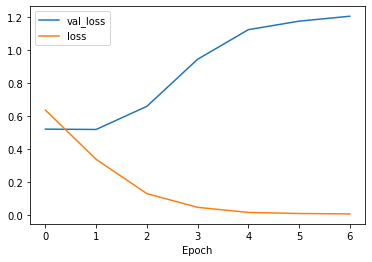

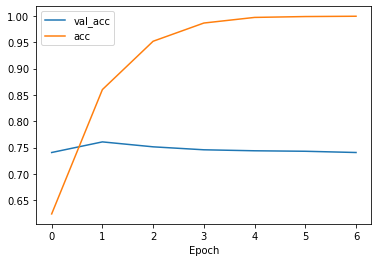

In [19]:
h = pd.DataFrame(history.history)
display(h)

h[['val_loss','loss']].plot();
plt.gca().set_xlabel('Epoch');

h[['val_acc','acc']].plot();
plt.gca().set_xlabel('Epoch');